# Задание: мультиклассовая классификация на 5 классов

In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Скачиваем данные

In [2]:
!wget https://github.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/blob/master/week_05/data/answers_subsample.csv?raw=true -O data.csv

--2020-01-13 12:48:29--  https://github.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/blob/master/week_05/data/answers_subsample.csv?raw=true
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/raw/master/week_05/data/answers_subsample.csv [following]
--2020-01-13 12:48:30--  https://github.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/raw/master/week_05/data/answers_subsample.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/week_05/data/answers_subsample.csv [following]
--2020-01-13 12:48:30--  https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/week_05/data/answers_subsample.csv
Resolving raw.githubusercontent.com (raw.gi

In [0]:
import pandas as pd

In [0]:
data = pd.read_csv('data.csv')

In [5]:
data.head()

,category,text
0,business,Могут ли в россельхозбанке дать в залог норков...
1,law,Может ли срочник перевестись на контракт после...
2,business,Продажа недвижимости по ипотеки ? ( арестованы...
3,business,"В чем смысл криптовалюты, какая от неё выгода ..."
4,law,часть 1 статья 158 похитил телефон


In [6]:
data.category.value_counts() * 100 / data.shape[0]

law         29.793211
relax       22.016242
business    19.309527
food        18.367055
love        10.513965
Name: category, dtype: float64

# Предобученные эмбеддинги
[Источник](https://fasttext.cc/docs/en/crawl-vectors.html)  

In [7]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
!gzip -d cc.ru.300.vec.gz

--2020-01-13 12:49:02--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.6.166, 104.20.22.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.6.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1306357571 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ru.300.vec.gz’

cc.ru.300.vec.gz    100%[===================>]   1.22G  12.4MB/s    in 1m 42s  

2020-01-13 12:50:46 (12.2 MB/s) - ‘cc.ru.300.vec.gz’ saved [1306357571/1306357571]



In [0]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm import tqdm, tqdm_notebook

In [0]:
def process_text(text):
    
    words = wordpunct_tokenize(text.lower())
    
    return words

In [10]:
word2freq = {}
lengths = []

for text in tqdm(data.text):
    
    words = process_text(text)
    
    lengths.append(len(words))
    
    for word in words:
        
        if word in word2freq:
            word2freq[word] += 1
        else:
            word2freq[word] = 1

100%|██████████| 237779/237779 [00:02<00:00, 107199.56it/s]


In [0]:
import seaborn as sns
from matplotlib import pyplot as plt

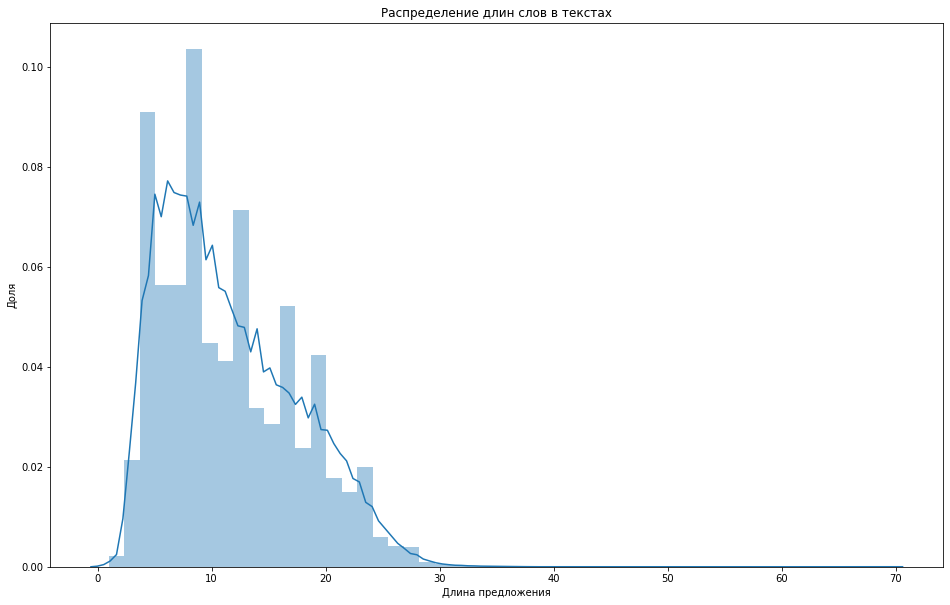

In [12]:
plt.figure(figsize=(16, 10))
plt.title('Распределение длин слов в текстах')
plt.xlabel('Длина предложения')
plt.ylabel('Доля')
sns.distplot(lengths)

In [13]:
upper_threshold = 32
lower_threshold = 3

correct_percent = len([sent_len for sent_len in lengths 
                       if sent_len <= upper_threshold and sent_len >= lower_threshold]) * 100 / len(lengths)

'{:.2f} % наших текстов входят в промежуток от {} до {} слов'.format(correct_percent, lower_threshold, upper_threshold)

'99.66 % наших текстов входят в промежуток от 3 до 32 слов'

In [14]:
len(word2freq)

152179

In [15]:
'{} слов, которые встречались 3 и менее раз'.format(len([word for word in word2freq if word2freq[word] <= 3]))

'114332 слов, которые встречались 3 и менее раз'

# Читаем файл с эмбеддингами
### Этот файл с 300 числами для 2 000 000 слов и он может не влезть в память
Поэтому прочитаем только те слова, которые мы знаем

In [0]:
import numpy as np

In [17]:
word2index = {'PAD': 0}
vectors = []
    
word2vec_file = open('cc.ru.300.vec')
    
n_words, embedding_dim = word2vec_file.readline().split()
n_words, embedding_dim = int(n_words), int(embedding_dim)

# Zero vector for PAD
vectors.append(np.zeros((1, embedding_dim)))

progress_bar = tqdm(desc='Read word2vec', total=n_words)

while True:

    line = word2vec_file.readline().strip()

    if not line:
        break
        
    current_parts = line.split()
    current_word = ' '.join(current_parts[:-embedding_dim])

    if current_word in word2freq:

        word2index[current_word] = len(word2index)
        
        current_vectors = current_parts[-embedding_dim:]
        current_vectors = np.array(list(map(float, current_vectors)))
        current_vectors = np.expand_dims(current_vectors, 0)

        vectors.append(current_vectors)

    progress_bar.update(1)

progress_bar.close()

word2vec_file.close()

vectors = np.concatenate(vectors)

Read word2vec: 100%|██████████| 2000000/2000000 [01:01<00:00, 32468.24it/s]


In [18]:
vectors.shape

(117619, 300)

In [19]:
len(word2index)

117619

In [20]:
unk_words = [word for word in word2freq if word not in word2index]
unk_counts = [word2freq[word] for word in unk_words]
n_unk = sum(unk_counts) * 100 / sum(list(word2freq.values()))

sub_sample_unk_words = {word: word2freq[word] for word in unk_words}
sorted_unk_words = list(sorted(sub_sample_unk_words, key=lambda x: sub_sample_unk_words[x], reverse=True))

print('Мы не знаем {:.2f} % слов в датасете'.format(n_unk))
print('Количество неизвестных слов {} из {}, то есть {:.2f} % уникальных слов в словаре'.format(
    len(unk_words), len(word2freq), len(unk_words) * 100 / len(word2freq)))
print('В среднем каждое встречается {:.2f} раз'.format(np.mean(unk_counts)))
print()
print('Топ 5 невошедших слов:')

for i in range(5):
    print(sorted_unk_words[i], 'с количеством вхождениий -', word2freq[sorted_unk_words[i]])

Мы не знаем 2.50 % слов в датасете
Количество неизвестных слов 34561 из 152179, то есть 22.71 % уникальных слов в словаре
В среднем каждое встречается 1.98 раз

Топ 5 невошедших слов:
??? с количеством вхождениий - 3641
?? с количеством вхождениий - 2448
!!! с количеством вхождениий - 2214
?) с количеством вхождениий - 2069
"? с количеством вхождениий - 1429


# Потеря 2.5 % слов в датасете

# GPU

In [0]:
import torch

In [22]:
print('Доступна ли видеокарта:', torch.cuda.is_available())
print('Если недоступна, поменяйте runtime, если в колабе')

Доступна ли видеокарта: True
Если недоступна, поменяйте runtime, если в колабе


In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Подготовим данные в DataLoader

In [0]:
from torch.utils.data import Dataset, DataLoader

In [24]:
'UNK' in word2index

False

In [25]:
data.head()

,category,text
0,business,Могут ли в россельхозбанке дать в залог норков...
1,law,Может ли срочник перевестись на контракт после...
2,business,Продажа недвижимости по ипотеки ? ( арестованы...
3,business,"В чем смысл криптовалюты, какая от неё выгода ..."
4,law,часть 1 статья 158 похитил телефон


# Замапим категории в индексы

In [0]:
cat_mapper = {cat: n for n, cat in enumerate(data.category.unique())}

In [27]:
cat_mapper

{'business': 0, 'food': 4, 'law': 1, 'love': 2, 'relax': 3}

In [0]:
data.category = data.category.map(cat_mapper)

# Читалка данных

In [0]:
class WordData(Dataset):
    
    def __init__(self, x_data, y_data, word2index, sequence_length=32, pad_token='PAD', verbose=True):
        
        super().__init__()
        
        self.x_data = []
        self.y_data = y_data
        
        self.word2index = word2index
        self.sequence_length = sequence_length
        
        self.pad_token = pad_token
        self.pad_index = self.word2index[self.pad_token]
        
        self.load(x_data, verbose=verbose)
        
    @staticmethod
    def process_text(text):
        words = wordpunct_tokenize(text.lower())
        return words
        
    def load(self, data, verbose=True):
        data_iterator = tqdm(data, desc='Loading data', disable=not verbose)
        
        for text in data_iterator:
            words = self.process_text(text)
            indexed_words = self.indexing(words)
            self.x_data.append(indexed_words)
    
    def indexing(self, tokenized_text):
        return [self.word2index[token] for token in tokenized_text if token in self.word2index ]
    
    def padding(self, sequence):
        if len(sequence) > self.sequence_length:
          sequence = sequence[:self.sequence_length]
        elif len(sequence) < self.sequence_length:
          sequence = sequence + [self.pad_index] * (self.sequence_length - len(sequence))

        return sequence
    
    def __len__(self):
        
        return len(self.x_data)
    
    def __getitem__(self, idx):
        
        x = self.x_data[idx]
        x = self.padding(x)
        x = torch.Tensor(x).long()
        
        y = self.y_data[idx]
        
        return x, y

In [30]:
dataset = WordData(data.text, data.category, word2index)

Loading data: 100%|██████████| 237779/237779 [00:02<00:00, 92252.60it/s]


In [0]:
data_loader = DataLoader(dataset, batch_size=128)

In [0]:
for x, y in data_loader:
    break

In [33]:
x

tensor([[  153,   137,     4,  ...,     0,     0,     0],
        [   65,   137, 97522,  ...,     0,     0,     0],
        [ 1584,   955,    17,  ...,     0,     0,     0],
        ...,
        [   24,  3730, 15501,  ...,     0,     0,     0],
        [ 3989,    19,    28,  ...,     0,     0,     0],
        [  593,  6504,   661,  ...,     0,     0,     0]])

In [34]:
y

tensor([0, 1, 0, 0, 1, 0, 0, 2, 1, 3, 0, 0, 4, 1, 2, 4, 4, 4, 1, 0, 3, 3, 1, 1,
        1, 2, 1, 1, 4, 2, 0, 1, 1, 4, 3, 4, 1, 4, 4, 3, 1, 1, 4, 1, 3, 3, 4, 4,
        1, 1, 1, 0, 1, 3, 0, 1, 2, 2, 4, 0, 4, 4, 0, 3, 4, 1, 2, 4, 0, 3, 3, 3,
        0, 3, 2, 0, 0, 2, 2, 1, 0, 1, 2, 1, 4, 1, 0, 0, 0, 3, 1, 3, 1, 3, 0, 3,
        0, 2, 1, 3, 4, 1, 1, 1, 1, 1, 3, 4, 0, 1, 1, 1, 3, 4, 1, 4, 4, 1, 0, 0,
        3, 3, 1, 1, 2, 4, 3, 3])

# Обучить нейронку

## План
1. Разбить датасет на трейн/тест или на трейн/валидация/тест, как вам больше нравится
1. Сделать класс нейронки, вписать необходимые операции, базовая архитектура ниже
1. Написать обучалку
1. Добавить логирование
    1. Сохранять лосс на каждой итерции обучения
    1. Каждую эпоху сохранять лосс трейна и тест
    1. Каждую эпоху рассчитывать метрики
    1. Добавить прогресс бар, в котором показывается усредненный лосс последних 500-та итераций
1. Добавить early stopping
1. Отрисовать графики лосса, метрик, конфьюжин матрицу
1. Улучшить результат. Например, можно добавить BatchNorm, Dropout, Residual, etc
1. Сделать макро f1 больше 0.8
1. Написать какие действия к чему приводили (почему вы их делали и оправдались ли ожидания)

## Базовая архитектура
1. Предобученные эмбеддинги. Почитайте [здесь](https://pytorch.org/docs/stable/nn.html#embedding) (from_pretrained) как вставить свои эмбеддинги, выше мы читали матрицу эмбеддингов.
1. Bidirectional LSTM.
2. Несколько параллельных CNN с разными размерами окна и пулингами к ним.
3. Конкатенация результатов CNN.
4. Предикт в количество классов.

__Дополнительные баллы:__
- Написать GRU с нуля самому __1 балл__
- Побить макро f1 0.84 __1 балл__
- Переобучиться и снизить переобучение за счет трюков. Пояснение: показываете, что вот такая архитектура переобучается, а вот я добавил/а это и это, изменил/а это и это и переобучение ушло __1 балл__
- Добавить селф аттеншин (написанный своими руками) __3 балла__
- За мультихед селф аттеншин еще __1 балл__
- Добавить [torch.nn.utils.rnn.pack_padded_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence) и [torch.nn.utils.rnn.pack_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_sequence) для LSTM. Инфа [здесь](#Еще-важный-момент-про-LSTM) __2 балла__
- Добавить дропаут для входа LSTM (не просто стандартный пункт при инициализации LSTM) __1 балл__
- Добавить шедуллеры __1 балл__
- your madness

In [0]:
from torch.utils.data import random_split
from torch import nn
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

In [0]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [0]:
train_data_loader = DataLoader(train_dataset, batch_size=64)
test_data_loader = DataLoader(test_dataset, batch_size=64)

Рассказ о применении различных штук для снижения переобучения ниже

In [0]:
class Classifier(torch.nn.Module):

  def __init__(self, vectors=vectors, hidden_dim_1=128, hidden_dim_2=64, 
               ngrams=[2, 3, 4, 5], n_classes=5, seq_len=32, keep_proba=0.5):

    super().__init__()

    self.hidden_dim_1 = hidden_dim_1
    self.hidden_dim_2 = hidden_dim_2

    self.vectors = vectors
    self.vocab_size, self.embedding_dim = self.vectors.shape

    self.embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(self.vectors))
    self.lstm_layer = nn.LSTM(self.embedding_dim, self.hidden_dim_1, batch_first=True, bidirectional=True)
    # self.bn1 = nn.BatchNorm1d(hidden_dim_1*2)

    self.convs = nn.ModuleList([nn.Conv1d(in_channels=self.hidden_dim_1*2, 
                                          out_channels = self.hidden_dim_2, 
                                          kernel_size = n) for n in ngrams])

    self.pooling = nn.ModuleList([nn.MaxPool1d(kernel_size=seq_len-n+1) for n in ngrams])
    self.dropout = nn.Dropout(p=keep_proba)
    self.linear_layer = nn.Linear(len(ngrams) * self.hidden_dim_2, n_classes)

  def forward(self, x):
    
    x = self.embedding_layer(x)
    lstm_x, mem = self.lstm_layer(x)
    lstm_transposed = self.dropout(lstm_x.transpose(1, 2))
    # lstm_transposed = lstm_x.transpose(1, 2)
    
    # conved = [conv(self.bn1(lstm_transposed)) for conv in self.convs]
    conved = [conv(lstm_transposed) for conv in self.convs]
    pooled = [pool(conv).squeeze(-1) for pool, conv in zip(self.pooling, conved)]
    cat = self.dropout(torch.cat(pooled, 1))
    # cat = torch.cat(pooled, 1)
    out = self.linear_layer(cat)

    return out

In [0]:
model = Classifier()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

model = model.to(device)
criterion = criterion.to(device)

In [44]:
epochs = 10
losses = []
best_test_loss = 10. # for early stopping

acc, macros, prec, rec = [], [], [], []
for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []
    test_pred_class = []
    
    progress_bar = tqdm(total=len(train_data_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for x, y in train_data_loader:

        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        pred = model(x)
        loss = criterion(pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    for x, y in test_data_loader:
        
      x = x.to(device)
      y = y.to(device)

      with torch.no_grad():
            
        pred = model(x)

        pred = pred.cpu()
        y = y.cpu()

        test_preds.append(pred.numpy())
        test_targets.append(y.numpy())
        test_pred_class.append(np.argmax(pred, axis=1))

        loss = criterion(pred, y)

        test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)

    test_targets = np.concatenate(test_targets).squeeze()
    test_pred_class = np.concatenate(test_pred_class).squeeze()
    
    accuracy = accuracy_score(test_targets, test_pred_class)
    precision = precision_score(test_targets, test_pred_class, average='macro')
    recall = recall_score(test_targets, test_pred_class, average='macro')
    f1 = f1_score(test_targets, test_pred_class, average='macro')

    acc.append(accuracy)
    macros.append(f1)
    prec.append(precision)
    rec.append(recall)
    
    print()
    print('Losses: train - {:.3f}, test - {:.3f}'.format(np.mean(train_losses), mean_test_loss))

    print('Test: accuracy - {:.3f}, precision - {:.3f}, recall - {:.3f}, f1 macro - {:.3f}'.format(accuracy, precision, recall, f1))
        
    # Early stopping:
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break


Epoch 2:   0%|          | 448/190223 [00:00<01:05, 2880.57it/s, train_loss=0.5]


Losses: train - 0.574, test - 0.497
Test: accuracy - 0.821, precision - 0.820, recall - 0.819, f1 macro - 0.820


Epoch 3:   0%|          | 448/190223 [00:00<01:08, 2787.28it/s, train_loss=0.468]


Losses: train - 0.477, test - 0.477
Test: accuracy - 0.827, precision - 0.829, recall - 0.823, f1 macro - 0.825


Epoch 4:   0%|          | 448/190223 [00:00<01:05, 2884.93it/s, train_loss=0.45]


Losses: train - 0.455, test - 0.471
Test: accuracy - 0.830, precision - 0.832, recall - 0.828, f1 macro - 0.830


Epoch 5:   0%|          | 448/190223 [00:00<01:07, 2825.10it/s, train_loss=0.432]


Losses: train - 0.438, test - 0.462
Test: accuracy - 0.835, precision - 0.836, recall - 0.832, f1 macro - 0.834


Epoch 6:   0%|          | 448/190223 [00:00<01:09, 2712.09it/s, train_loss=0.42]


Losses: train - 0.425, test - 0.459
Test: accuracy - 0.835, precision - 0.836, recall - 0.831, f1 macro - 0.833


Epoch 6: 100%|██████████| 190223/190223 [01:07<00:00, 2830.87it/s, train_loss=0.407]



Losses: train - 0.412, test - 0.459
Test: accuracy - 0.836, precision - 0.837, recall - 0.834, f1 macro - 0.835
Early stopping


In [45]:
best_test_loss

0.4587385871632886

- Базовая модель:
```
best_test_loss - 0.45
f1 macro - 0.833
early stopping после 4 эпохи
```
- Пробовала менять learning rate в обе стороны, но получалось хуже по качеству (lr=0.01) или медленнее (lr=0.002)

- Добавила дропаут после LSTM:
```
best_test_loss - 0.45
f1 macro - 0.834
early stopping после 6 эпохи
```

- Дропаут после LSTM + дропаут после CNN:
```
best_test_loss - 0.45
f1 macro - 0.835
early stopping после 7 эпохи
```

- 2 дропаута + батчнорм:
```
best_test_loss - 0.46
f1 macro - 0.831
early stopping после 7 эпохи
```
получилось хуже, поэтому я убрала батч норм

Text(0, 0.5, 'Loss function')

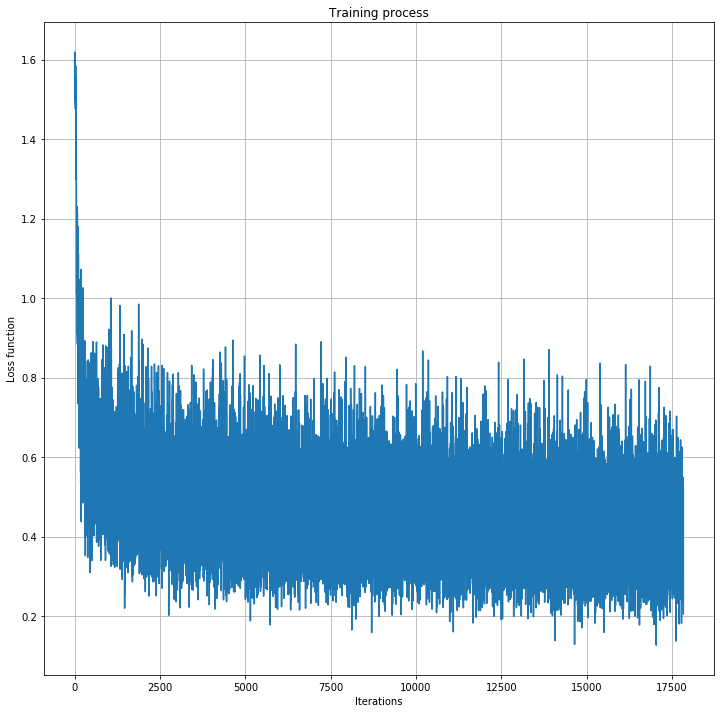

In [46]:
plt.figure(figsize=(12, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

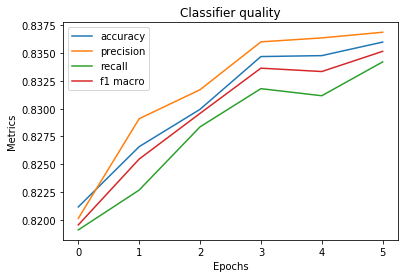

In [47]:
plt.plot(acc)
plt.plot(prec)
plt.plot(rec)
plt.plot(macros)
plt.title('Classifier quality')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend(['accuracy', 'precision', 'recall', 'f1 macro'], loc='upper left')

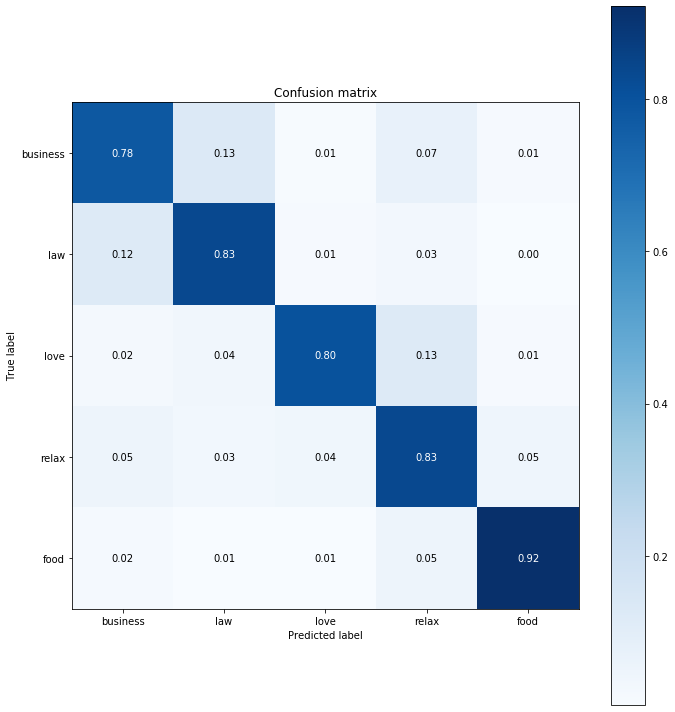

In [48]:
cm = confusion_matrix(test_targets, test_pred_class)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

classes = unique_labels(test_targets, test_pred_class)
cat_mapper = sorted(cat_mapper.items(), key=lambda x: x[1])

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
       xticklabels=[k[0] for k in cat_mapper], yticklabels=[k[0] for k in cat_mapper],
       title='Confusion matrix', ylabel='True label', xlabel='Predicted label')

fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()


plt.show()

Та же модель, но с self-attention:

In [0]:
from math import sqrt

In [0]:
class ClassifierWithAttn(torch.nn.Module):

  def __init__(self, vectors=vectors, hidden_dim_1=128, hidden_dim_2=64, 
               ngrams=[2, 3, 4, 5], n_classes=5, seq_len=32, keep_proba=0.5):

    super().__init__()

    self.hidden_dim_1 = hidden_dim_1
    self.hidden_dim_2 = hidden_dim_2

    self.vectors = vectors
    self.vocab_size, self.embedding_dim = self.vectors.shape

    self.embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(self.vectors))
    self.lstm_layer = nn.LSTM(self.embedding_dim, self.hidden_dim_1, batch_first=True, bidirectional=True)
    
    # слои для Attention
    self.key = nn.Linear(in_features=self.hidden_dim_1*2, out_features=self.hidden_dim_1*2)
    self.query = nn.Linear(in_features=self.hidden_dim_1*2, out_features=self.hidden_dim_1*2)
    self.value = nn.Linear(in_features=self.hidden_dim_1*2, out_features=self.hidden_dim_1*2)

    self.convs = nn.ModuleList([nn.Conv1d(in_channels=self.hidden_dim_1*2, 
                                          out_channels = self.hidden_dim_2, 
                                          kernel_size = n) for n in ngrams])

    self.pooling = nn.ModuleList([nn.MaxPool1d(kernel_size=seq_len-n+1) for n in ngrams])
    self.dropout = nn.Dropout(p=keep_proba)
    self.linear_layer = nn.Linear(len(ngrams) * self.hidden_dim_2, n_classes)

  def forward(self, x):
    
    x = self.embedding_layer(x)
    lstm_x, mem = self.lstm_layer(x)

    x_key = self.key(lstm_x)
    x_query = self.query(lstm_x)
    x_value = self.value(lstm_x)

    attention_scores = torch.bmm(x_query, x_key.transpose(1, 2)) / sqrt(self.hidden_dim_1*2)
    attention_distribution = torch.nn.functional.softmax(attention_scores, dim=2)

    x_attn = torch.bmm(attention_distribution, x_value)
    x_transposed = self.dropout(x_attn.transpose(1, 2))
    
    conved = [conv(x_transposed) for conv in self.convs]
    pooled = [pool(conv).squeeze(-1) for pool, conv in zip(self.pooling, conved)]
    cat = self.dropout(torch.cat(pooled, 1))
    out = self.linear_layer(cat)

    return out

In [0]:
model = ClassifierWithAttn()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

model = model.to(device)
criterion = criterion.to(device)

In [52]:
epochs = 10
losses = []
best_test_loss = 10.

acc, macros, prec, rec = [], [], [], []
for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []
    test_pred_class = []
    
    progress_bar = tqdm(total=len(train_data_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for x, y in train_data_loader:

        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        pred = model(x)
        loss = criterion(pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    for x, y in test_data_loader:
        
      x = x.to(device)
      y = y.to(device)

      with torch.no_grad():
            
        pred = model(x)

        pred = pred.cpu()
        y = y.cpu()

        test_preds.append(pred.numpy())
        test_targets.append(y.numpy())
        test_pred_class.append(np.argmax(pred, axis=1))

        loss = criterion(pred, y)

        test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)

    test_targets = np.concatenate(test_targets).squeeze()
    test_pred_class = np.concatenate(test_pred_class).squeeze()
    
    accuracy = accuracy_score(test_targets, test_pred_class)
    precision = precision_score(test_targets, test_pred_class, average='macro')
    recall = recall_score(test_targets, test_pred_class, average='macro')
    f1 = f1_score(test_targets, test_pred_class, average='macro')

    acc.append(accuracy)
    macros.append(f1)
    prec.append(precision)
    rec.append(recall)
    
    print()
    print('Losses: train - {:.3f}, test - {:.3f}'.format(np.mean(train_losses), mean_test_loss))

    print('Test: accuracy - {:.3f}, precision - {:.3f}, recall - {:.3f}, f1 macro - {:.3f}'.format(accuracy, precision, recall, f1))
        
    # Early stopping:
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break


Epoch 2:   0%|          | 384/190223 [00:00<01:16, 2472.15it/s, train_loss=0.488]


Losses: train - 0.553, test - 0.487
Test: accuracy - 0.825, precision - 0.826, recall - 0.821, f1 macro - 0.823


Epoch 3:   0%|          | 384/190223 [00:00<01:16, 2481.99it/s, train_loss=0.458]


Losses: train - 0.466, test - 0.471
Test: accuracy - 0.831, precision - 0.833, recall - 0.828, f1 macro - 0.830


Epoch 4:   0%|          | 384/190223 [00:00<01:21, 2340.88it/s, train_loss=0.437]


Losses: train - 0.444, test - 0.464
Test: accuracy - 0.834, precision - 0.838, recall - 0.827, f1 macro - 0.832


Epoch 5:   0%|          | 384/190223 [00:00<01:21, 2332.82it/s, train_loss=0.419]


Losses: train - 0.427, test - 0.462
Test: accuracy - 0.836, precision - 0.840, recall - 0.831, f1 macro - 0.835


Epoch 5: 100%|██████████| 190223/190223 [01:20<00:00, 2371.23it/s, train_loss=0.401]



Losses: train - 0.409, test - 0.463
Test: accuracy - 0.838, precision - 0.842, recall - 0.834, f1 macro - 0.837
Early stopping


Качество стало чуть лучше, но не слишком

In [56]:
best_test_loss

0.4615721121550568

Text(0, 0.5, 'Loss function')

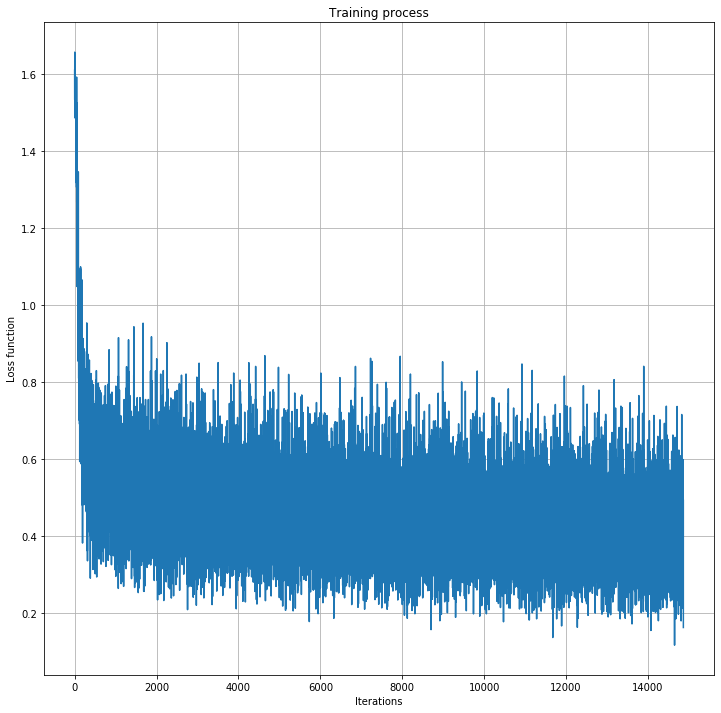

In [57]:
plt.figure(figsize=(12, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

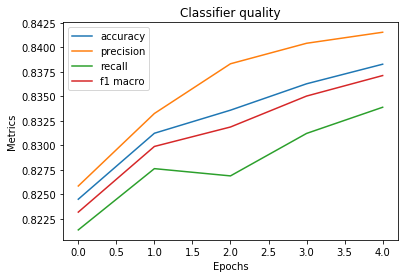

In [58]:
plt.plot(acc)
plt.plot(prec)
plt.plot(rec)
plt.plot(macros)
plt.title('Classifier quality')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend(['accuracy', 'precision', 'recall', 'f1 macro'], loc='upper left')